# Introduction to Generative Adversarial Networks (GANs)

Generative adversarial networks (GANs), introduced in 2014 by Goodfellow et al., are an alternative to VAEs for learning latent spaces of images. They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones. 



An intuitive way to understand GANs is to imagine a forger trying to create a fake Picasso painting. At first, the forger is pretty bad at the task. He mixes some of his fakes with authentic Picassos and shows them all to an art dealer. The art dealer makes an authenticity assessment for each painting and gives the forger feedback about what makes a Picasso look like a Picasso. The forger goes back to his studio to prepare some new fakes. As times goes on, the forger becomes increasingly competent at imitating the style of Picasso, and the art dealer becomes increasingly expert at spotting fakes. In the end, they have on their hands some excellent fake Picassos.

That’s what a GAN is: a forger network and an expert network, each being trained to best the other. As such, a GAN is made of two parts:

- **Generator network**--Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image. 

- **Discriminator network**--Takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the generator network.

The generator network is trained to be able to fool the discriminator network, and thus it evolves toward generating increasingly realistic images as training goes on: artificial images that look indistinguishable from real ones, to the extent that it’s impossible for the discriminator network to tell the two apart.
![](assets/08fig15_alt.jpg)
Meanwhile, the discriminator is constantly adapting to the gradually improving capabilities of the generator, setting a high bar of realism for the generated images. Once training is over, the generator is capable of turning any point in its input space into a believable image. Unlike VAEs, this latent space has fewer explicit guarantees of meaningful structure; in particular, it isn’t continuous. 

Remarkably, a GAN is a system where the optimization minimum isn’t fixed, unlike in any other training setup you’ve encountered in this book. Normally, gradient descent consists of rolling down hills in a static loss landscape. But with a GAN, every step taken down the hill changes the entire landscape a little. It’s a dynamic system where the optimization process is seeking not a minimum, but an equilibrium between two forces. For this reason, GANs are notoriously difficult to train—getting a GAN to work requires lots of careful tuning of the model architecture and training parameters. 

##  A schematic GAN implementation 

In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the technical details would be out of scope for us. Our specific implementation will be a **deep convolutional GAN, or DCGAN**: a GAN where the generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

We will train our GAN on images from *CIFAR10*, a dataset of `50,000 32x32` RGB images belong to 10 classes (5,000 images per class). To make things even easier, we will only use images belonging to the class "frog".


Schematically, the GAN looks like this:

1. A **generator network** maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
    
2. A **discriminator network** maps images of shape `(32, 32, 3)` to a binary score estimating the probability that the image is real.

3. A **gan network** chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.

4. You train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as you train any regular image-classification model.

5. To train the generator, you use the gradients of the generator’s weights with regard to the loss of the gan model. This means, at every step, you move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, you train the generator to fool the discriminator.


## A bag of tricks



The process of training GANs and tuning GAN implementations is notoriously difficult. There are a number of known tricks you should keep in mind. Like most things in deep learning, it’s more alchemy than science: these tricks are heuristics, not theory-backed guidelines. They’re supported by a level of intuitive understanding of the phenomenon at hand, and they’re known to work well empirically, although not necessarily in every context.

Here are a few of the tricks used in the implementation of the GAN generator and discriminator in this section. It isn’t an exhaustive list of GAN-related tips; you’ll find many more across the GAN literature:


- We use `tanh` as the last activation in the generator, instead of sigmoid, which is more commonly found in other types of models.

- We sample points from the latent space using a normal distribution (Gaussian distribution), not a uniform distribution.

- Stochasticity is good to induce robustness. Because GAN training results in a dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness in two ways: 
 - by using dropout in the discriminator and 
 - by adding random noise to the labels for the discriminator.
 
- Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. Two things can induce gradient sparsity: max pooling operations and ReLU activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a LeakyReLU layer instead of a ReLU activation. It’s similar to ReLU, but it relaxes sparsity constraints by allowing small negative activation values.
    
- In generated images, it’s common to see checkerboard artifacts caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that’s divisible by the stride size whenever we use a strided Conv2DTranpose or Conv2D in both the generator and the discriminator.
![](assets/08fig17.jpg)


## The generator

First, let's develop a generator model that turns a vector (from latent space--during training it will be sampled at random) into a candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use dropout on both the discriminator and the generator. 

In [1]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

## The discriminator

Next, we develop a `discriminator` model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes:

- Generated image or
- Real image that comes from the training set

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

## The adversarial network 

Finally, you’ll set up the GAN, which chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its ability to fool the discriminator. This model turns latent-space points into a classification decision—“fake” or “real”—and it’s meant to be trained with labels that are always “these are real images.” So, training gan will update the weights of generator in a way that makes discriminator more likely to predict “real” when looking at fake images. It’s very important to note that you set the discriminator to be frozen during training (non-trainable): its weights won’t be updated when training gan. If the discriminator weights could be updated during this process, then you’d be training the discriminator to always predict “real,” which isn’t what you want! 

In [3]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [4]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_2 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________



## How to train your DCGAN
Now we can start training. To recapitulate, this is schematically what the training loop looks like:

for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.

Let's implement it:

In [5]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/home/ubuntu/deep-learning/gan-outputs/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))


/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.7087188
adversarial loss at step 0: 0.7043257
discriminator loss at step 100: 0.6805792
adversarial loss at step 100: 1.0738816
discriminator loss at step 200: 0.69325984
adversarial loss at step 200: 0.826261
discriminator loss at step 300: 0.69020945
adversarial loss at step 300: 0.75731623
discriminator loss at step 400: 0.69574577
adversarial loss at step 400: 0.7477096
discriminator loss at step 500: 0.6927186
adversarial loss at step 500: 0.7514777
discriminator loss at step 600: 0.71385115
adversarial loss at step 600: 0.7544489
discriminator loss at step 700: 0.7045494
adversarial loss at step 700: 0.7852041
discriminator loss at step 800: 0.69250816
adversarial loss at step 800: 0.76614916
discriminator loss at step 900: 0.69649494
adversarial loss at step 900: 0.7422373
discriminator loss at step 1000: 0.7986571
adversarial loss at step 1000: 0.83583724
discriminator loss at step 1100: 0.70193136
adversarial loss at step 1100: 0.7896347
discrim

KeyboardInterrupt: 

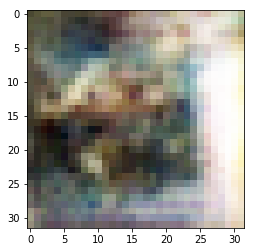

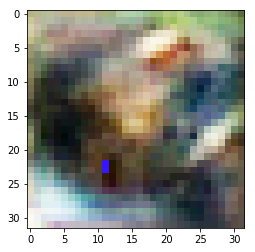

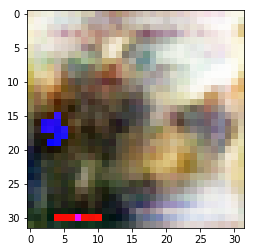

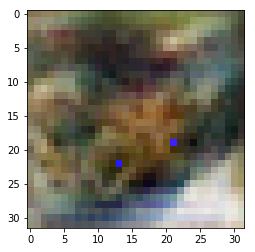

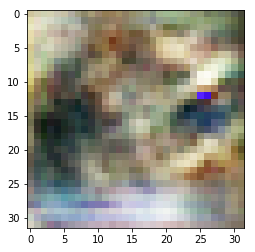

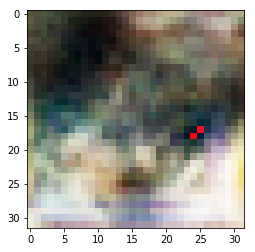

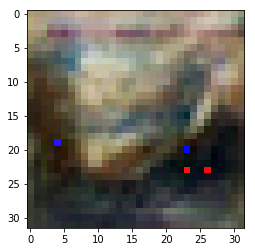

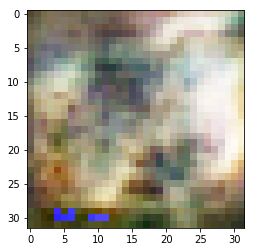

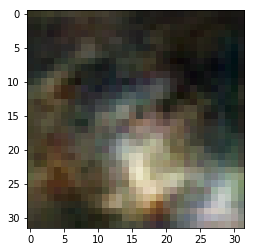

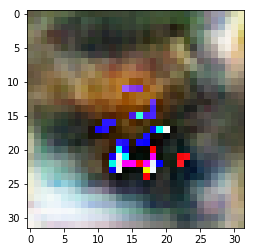

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()



## Key Takeaways

- A GAN consists of a generator network coupled with a discriminator network. The discriminator is trained to differenciate between the output of the generator and real images from a training dataset, and the generator is trained to fool the discriminator. Remarkably, the generator nevers sees images from the training set directly; the information it has about the data comes from the discriminator.
- GANs are difficult to train, because training a GAN is a dynamic process rather than a simple gradient descent process with a fixed loss landscape. Getting a GAN to train correctly requires using a number of heuristic tricks, as well as extensive tuning.
- GANs can potentially produce highly realistic images. But unlike VAEs, the latent space they learn doesn’t have a neat continuous structure and thus may not be suited for certain practical applications, such as image editing via latent-space concept vectors. 